In [235]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [236]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx         # _token_to_idx: {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}
                                                  # _idx_to_token: {0:'<UNK>', 1:'apple', 2:'banana', ....., 10000:'zzz'}

        self._idx_to_token = {idx: token          
                              for token, idx in self._token_to_idx.items()} 
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
              
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:                   # if unk_token is defined, unknown words are handled
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [237]:
class TweetVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, tweet_vocab, label_vocab):
        """
        Args:
            tweet_vocab (Vocabulary): maps words to integers
            label_vocab (Vocabulary): maps class labels to integers; {'negative':0, 'neutral':1, 'positive':2}
        """
        self.tweet_vocab = tweet_vocab    
        self.label_vocab = label_vocab     

    def vectorize(self, tweet):
        """Create a collapsed one-hot vector for the tweet
        
        Args:
            tweet (str): the tweet text
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding
        """
        one_hot = np.zeros(len(self.tweet_vocab), dtype=np.float32)
        
        for token in tweet.split(" "):
            if token not in string.punctuation:
                one_hot[self.tweet_vocab.lookup_token(token)] = 1

        return one_hot  

    @classmethod
    def from_dataframe(cls, tweet_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            cls: class name, i.e., TweetVectorizer
            tweet_df (pandas.DataFrame): the dataset containing tweets
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the TweetVectorizer
        """
        tweet_vocab = Vocabulary(add_unk=True)   
        label_vocab = Vocabulary(add_unk=False)
        
        for label in sorted(set(tweet_df.label)):  
            label_vocab.add_token(label)       

        word_counts = Counter()
        for tweet in tweet_df.processed_text:
            for word in tweet.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                tweet_vocab.add_token(word)    

        return cls(tweet_vocab, label_vocab)


In [238]:
class TweetDataset(Dataset):
    def __init__(self, tweet_df, vectorizer):
        """
        Args:
            tweet_df (pandas.DataFrame): the dataset
            vectorizer (TweetVectorizer): vectorizer instantiated from dataset
        """
        self.tweet_df = tweet_df
        self._vectorizer = vectorizer

        self.train_df = self.tweet_df[self.tweet_df.split == 'train']
        self.train_size = len(self.train_df)

        self.val_df = self.tweet_df[self.tweet_df.split == 'val']
        self.validation_size = len(self.val_df)

        self.test_df = self.tweet_df[self.tweet_df.split == 'test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, tweet_csv, frequency_cutoff):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            cls: class name, i.e. TweetDataset
            tweet_csv (str): location of the dataset
        Returns:
            an instance of TweetDataset
        """
        tweet_df = pd.read_csv(tweet_csv)
        train_tweet_df = tweet_df[tweet_df.split == 'train']
        return cls(tweet_df, TweetVectorizer.from_dataframe(train_tweet_df, frequency_cutoff))
    
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        tweet_vector = \
            self._vectorizer.vectorize(row.processed_text)

        label_index = \
            self._vectorizer.label_vocab.lookup_token(row.label)

        return {'x_data': tweet_vector,           #  e.g., { 'x_data': [0, 0, 1, 0, 1, ....., 0, 0],
                'y_target': label_index}          #          'y_target': 1  }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  # the floor division // rounds the result down to the nearest whole number
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)
    
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():  # name: x_data & y_target
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


In [239]:
class TweetClassifier(nn.Module):
    """A simple perceptron-based classifier for multi-class classification"""
    #def __init__(self, num_features, hidden_dim, num_classes):
    def __init__(self, num_features, hidden_dim, hidden2_dim, num_classes):
        """
        Args:
            num_features (int): the size of the input feature vector
            hidden_dim (int): the size of hidden dimension
            num_classes (int): the number of output classes (e.g., 3 for sentiment analysis)
        """
        super(TweetClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=hidden2_dim)
        self.fc3 = nn.Linear(in_features=hidden2_dim, out_features=num_classes)
        
        
        #self.fc1 = nn.Linear(in_features=num_features, out_features=hidden_dim)
        #self.fc2 = nn.Linear(in_features=hidden_dim, out_features=num_classes)
        #self.bn1 = nn.BatchNorm1d(hidden_dim)
        #self.dpout = nn.Dropout(p=0.2)

    def forward(self, x_in):
        """The forward pass of the classifier    
        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be [batch, num_features]
        Returns:
            the resulting tensor. tensor.shape should be [batch, num_classes]
        """
        intermediate = self.fc1(x_in)            # [batch, num_features] -> [batch, hidden_dim]
        #intermediate = self.bn1(intermediate)
        intermediate = F.relu(intermediate)      # [batch, hidden_dim]
        #intermediate = self.dpout(intermediate)
        intermediate = F.relu(self.fc2(intermediate))
        
        y_out = self.fc3(intermediate)           # [batch, hidden_dim] -> [batch, num_classes]
        
        return F.log_softmax(y_out, dim=1)       # Log-Softmax for multi-class classification


In [240]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better.

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """
    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    """Compute the accuracy for multi-class classification

    Args:
        y_pred (torch.Tensor): the predicted probabilities for each class
        y_target (torch.Tensor): the ground truth labels
    Returns:
        float: accuracy as a percentage
    """
    y_target = y_target.cpu()
    y_pred_indices = torch.argmax(y_pred, dim=1).cpu()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()  # item() to get a Python number from a tensor containing a single value
    return n_correct / len(y_pred_indices) * 100

In [241]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [242]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=25,  
    model_state_file='tweet_model.pth', 
    tweet_csv='data_preprocess.csv', 
    save_dir='model_storage/tweet_sentiment/',  
    # Model hyperparameters
    hidden_dim=500,
    hidden2_dim=128,
    num_classes=3, 
    # Training hyperparameters
    batch_size=64,  
    early_stopping_criteria=5, 
    learning_rate=0.002, 
    num_epochs=50, 
    seed=42, 
    # Runtime options
    catch_keyboard_interrupt=True,  
    cuda=True,  
    expand_filepaths_to_save_dir=True,  
    reload_from_files=False,  
)

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# Handle directories; create them if they don't exist
handle_dirs(args.save_dir)


Expanded filepaths: 
	model_storage/tweet_sentiment/tweet_model.pth
Using CUDA: False


In [243]:
print("Loading dataset and creating vectorizer")
# Create dataset and vectorizer
dataset = TweetDataset.load_dataset_and_make_vectorizer(args.tweet_csv, args.frequency_cutoff)

vectorizer = dataset.get_vectorizer()

# Initialize classifier for three classes
classifier = TweetClassifier(num_features=len(vectorizer.tweet_vocab), 
                             hidden_dim=args.hidden_dim,
                             hidden2_dim=args.hidden2_dim,
                             num_classes=args.num_classes)

# Move the classifier to the appropriate device
classifier = classifier.to(args.device)


Loading dataset and creating vectorizer


In [244]:
classifier = classifier.to(args.device)

# Use CrossEntropyLoss for multi-class classification
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
#optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.1,
                                                 patience=10)  # Reduce learning rate when a metric has stopped improving.

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)  # progress bar

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Training phase
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # Step 1. Zero the gradients
            optimizer.zero_grad()

            # Step 2. Compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())  # [batch, num_features] -> [batch, num_classes]

            # Step 3. Compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].long())  # Use CrossEntropyLoss
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # Step 4. Backpropagate
            loss.backward()

            # Step 5. Update the weights
            optimizer.step()

            # Compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update progress bar
            train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()
        
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)
        
        # Validation phase
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # Compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # Compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].long())  # Use CrossEntropyLoss
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # Compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


training routine:   0%|          | 0/50 [00:00<?, ?it/s]

split=train:   0%|          | 0/499 [00:00<?, ?it/s]

split=val:   0%|          | 0/107 [00:00<?, ?it/s]

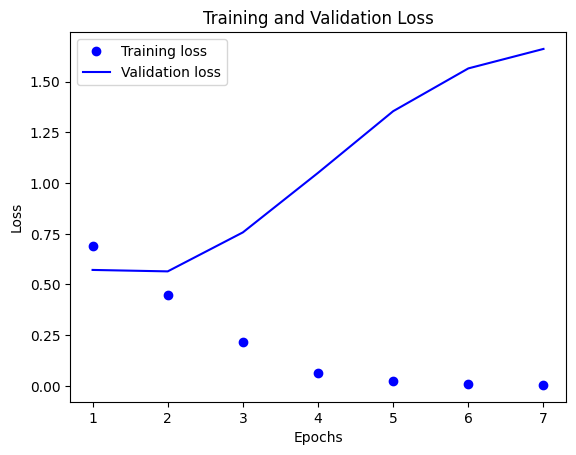

In [245]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# Extract training and validation metrics
acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Training and Validation Loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

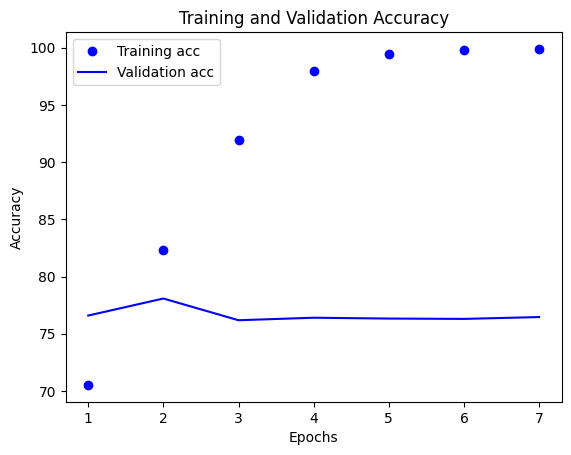

In [246]:
plt.clf()   # Clear figure

# Plot Training and Validation Accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [247]:
# Compute the loss & accuracy on the test set using the best available model
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.0
running_acc = 0.0
classifier.eval()

y_pred_list = []    # Store predicted values for confusion matrix
y_target_list = []  # Ground truth values

for batch_index, batch_dict in enumerate(batch_generator):
    # Compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())
    
    # Store predicted values and ground truth values
    y_pred_list.extend(torch.argmax(y_pred, dim=1).cpu().numpy())  # Use argmax for multi-class
    y_target_list.extend(batch_dict['y_target'].cpu().numpy())
    
    # Compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].long())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # Compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15876\1448567105.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(train_state['m

Test loss: 0.591
Test Accuracy: 77.63


In [248]:
# Prepare confusion matrix and classification report
rating_classes = []
for i in range(len(dataset._vectorizer.label_vocab)):
    rating_classes.append(dataset._vectorizer.label_vocab.lookup_index(i))
print(rating_classes)

['negative', 'neutral', 'positive']


In [249]:
cm = confusion_matrix(y_target_list, y_pred_list)
cm_df = pd.DataFrame(cm, index=rating_classes, columns=rating_classes)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
print(cm_df)

Predicted  negative  neutral  positive
True                                  
negative       1933      212       154
neutral         360      751       395
positive        195      216      2632


In [250]:
print(classification_report(y_target_list, y_pred_list, target_names=rating_classes))

              precision    recall  f1-score   support

    negative       0.78      0.84      0.81      2299
     neutral       0.64      0.50      0.56      1506
    positive       0.83      0.86      0.85      3043

    accuracy                           0.78      6848
   macro avg       0.75      0.73      0.74      6848
weighted avg       0.77      0.78      0.77      6848



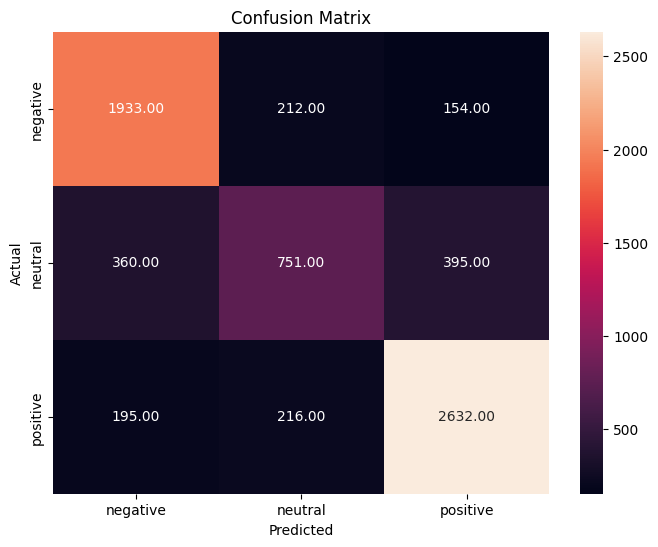

In [251]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


labels = list(vectorizer.label_vocab._idx_to_token.values())

conf_matrix = confusion_matrix(y_target_list, y_pred_list)

plt.figure(figsize=(8, 6)) 
sns.heatmap(conf_matrix, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()